In [1]:
!python -V

Python 3.9.19


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

In [6]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-learn/01-intro/mlruns/1', creation_time=1723565857348, experiment_id='1', last_update_time=1723565857348, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829577

/tmp/ipykernel_3158/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_3158/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


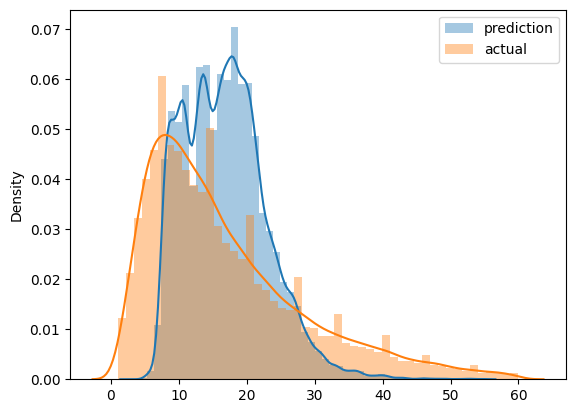

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [12]:
len(df_train), len(df_val)

(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715209663881

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
with mlflow.start_run():
    mlflow.set_tag("developer", "chris")
    
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")
    
    alpha = 0.1

    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_val)
    
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

In [19]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [22]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [26]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [27]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|                                                                                     | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:24:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.32254                                                                                                     
[1]	validation-rmse:9.04898                                                                                                      
[2]	validation-rmse:8.21468                                                                                                      
[3]	validation-rmse:7.68114                                                                                                      
[4]	validation-rmse:7.34180                                                                                                      
[5]	validation-rmse:7.12859                                                                                                      
[6]	validation-rmse:6.99271                                                                                                      
[7]	validation-rmse:6.90537                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:26:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.89216                                                                                                      
[1]	validation-rmse:6.75206                                                                                                      
[2]	validation-rmse:6.73726                                                                                                      
[3]	validation-rmse:6.73086                                                                                                      
[4]	validation-rmse:6.72253                                                                                                      
[5]	validation-rmse:6.71045                                                                                                      
[6]	validation-rmse:6.70862                                                                                                      
[7]	validation-rmse:6.70518                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:27:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.63357                                                                                                      
[1]	validation-rmse:8.23325                                                                                                      
[2]	validation-rmse:7.51189                                                                                                      
[3]	validation-rmse:7.15145                                                                                                      
[4]	validation-rmse:6.97083                                                                                                      
[5]	validation-rmse:6.87503                                                                                                      
[6]	validation-rmse:6.82579                                                                                                      
[7]	validation-rmse:6.79097                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:28:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.79870                                                                                                      
[1]	validation-rmse:6.74348                                                                                                      
[2]	validation-rmse:6.72783                                                                                                      
[3]	validation-rmse:6.72293                                                                                                      
[4]	validation-rmse:6.71637                                                                                                      
[5]	validation-rmse:6.71526                                                                                                      
[6]	validation-rmse:6.70812                                                                                                      
[7]	validation-rmse:6.69745                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:29:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.34994                                                                                                      
[1]	validation-rmse:6.76383                                                                                                      
[2]	validation-rmse:6.66505                                                                                                      
[3]	validation-rmse:6.64608                                                                                                      
[4]	validation-rmse:6.63058                                                                                                      
[5]	validation-rmse:6.62288                                                                                                      
[6]	validation-rmse:6.61286                                                                                                      
[7]	validation-rmse:6.60714                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:29:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.59677                                                                                                      
[1]	validation-rmse:8.15662                                                                                                      
[2]	validation-rmse:7.40651                                                                                                      
[3]	validation-rmse:7.02338                                                                                                      
[4]	validation-rmse:6.82335                                                                                                      
[5]	validation-rmse:6.71377                                                                                                      
[6]	validation-rmse:6.64798                                                                                                      
[7]	validation-rmse:6.61072                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:31:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.04503                                                                                                      
[1]	validation-rmse:6.68678                                                                                                      
[2]	validation-rmse:6.62337                                                                                                      
[3]	validation-rmse:6.60743                                                                                                      
[4]	validation-rmse:6.59180                                                                                                      
[5]	validation-rmse:6.58357                                                                                                      
[6]	validation-rmse:6.58061                                                                                                      
[7]	validation-rmse:6.57341                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:32:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.61138                                                                                                     
[1]	validation-rmse:11.06902                                                                                                     
[2]	validation-rmse:10.58136                                                                                                     
[3]	validation-rmse:10.14421                                                                                                     
[4]	validation-rmse:9.75273                                                                                                      
[5]	validation-rmse:9.40314                                                                                                      
[6]	validation-rmse:9.09172                                                                                                      
[7]	validation-rmse:8.81474                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:34:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.95173                                                                                                      
[1]	validation-rmse:8.56065                                                                                                      
[2]	validation-rmse:7.73651                                                                                                      
[3]	validation-rmse:7.25905                                                                                                      
[4]	validation-rmse:6.98892                                                                                                      
[5]	validation-rmse:6.83127                                                                                                      
[6]	validation-rmse:6.73278                                                                                                      
[7]	validation-rmse:6.67224                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:35:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.26332                                                                                                     
[1]	validation-rmse:10.45796                                                                                                     
[2]	validation-rmse:9.77845                                                                                                      
[3]	validation-rmse:9.20854                                                                                                      
[4]	validation-rmse:8.73122                                                                                                      
[5]	validation-rmse:8.33579                                                                                                      
[6]	validation-rmse:8.00876                                                                                                      
[7]	validation-rmse:7.74094                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:38:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.30352                                                                                                     
[1]	validation-rmse:9.01438                                                                                                      
[2]	validation-rmse:8.16625                                                                                                      
[3]	validation-rmse:7.61979                                                                                                      
[4]	validation-rmse:7.27282                                                                                                      
[5]	validation-rmse:7.05290                                                                                                      
[6]	validation-rmse:6.91357                                                                                                      
[7]	validation-rmse:6.81803                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:40:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.08544                                                                                                     
[1]	validation-rmse:8.72742                                                                                                      
[2]	validation-rmse:7.89268                                                                                                      
[3]	validation-rmse:7.36177                                                                                                      
[4]	validation-rmse:7.05863                                                                                                      
[5]	validation-rmse:6.87682                                                                                                      
[6]	validation-rmse:6.75884                                                                                                      
[7]	validation-rmse:6.68538                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:42:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79677                                                                                                     
[1]	validation-rmse:11.40856                                                                                                     
[2]	validation-rmse:11.04654                                                                                                     
[3]	validation-rmse:10.70892                                                                                                     
[4]	validation-rmse:10.39614                                                                                                     
[5]	validation-rmse:10.10256                                                                                                     
[6]	validation-rmse:9.83326                                                                                                      
[7]	validation-rmse:9.58202                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:47:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.36898                                                                                                     
[1]	validation-rmse:10.63803                                                                                                     
[2]	validation-rmse:10.00833                                                                                                     
[3]	validation-rmse:9.46776                                                                                                      
[4]	validation-rmse:9.00605                                                                                                      
[5]	validation-rmse:8.61325                                                                                                      
[6]	validation-rmse:8.28070                                                                                                      
[7]	validation-rmse:7.99882                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:51:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.35360                                                                                                      
[1]	validation-rmse:7.95908                                                                                                      
[2]	validation-rmse:7.31654                                                                                                      
[3]	validation-rmse:7.03046                                                                                                      
[4]	validation-rmse:6.89614                                                                                                      
[5]	validation-rmse:6.83331                                                                                                      
[6]	validation-rmse:6.79905                                                                                                      
[7]	validation-rmse:6.78059                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:52:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.21307                                                                                                     
[1]	validation-rmse:8.90311                                                                                                      
[2]	validation-rmse:8.07105                                                                                                      
[3]	validation-rmse:7.55734                                                                                                      
[4]	validation-rmse:7.23937                                                                                                      
[5]	validation-rmse:7.04550                                                                                                      
[6]	validation-rmse:6.92714                                                                                                      
[7]	validation-rmse:6.84942                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:54:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.24023                                                                                                      
[1]	validation-rmse:7.77000                                                                                                      
[2]	validation-rmse:7.08771                                                                                                      
[3]	validation-rmse:6.77856                                                                                                      
[4]	validation-rmse:6.62566                                                                                                      
[5]	validation-rmse:6.55033                                                                                                      
[6]	validation-rmse:6.50731                                                                                                      
[7]	validation-rmse:6.48001                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:55:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.26054                                                                                                     
[1]	validation-rmse:8.94538                                                                                                      
[2]	validation-rmse:8.08348                                                                                                      
[3]	validation-rmse:7.53194                                                                                                      
[4]	validation-rmse:7.18359                                                                                                      
[5]	validation-rmse:6.96229                                                                                                      
[6]	validation-rmse:6.82074                                                                                                      
[7]	validation-rmse:6.72854                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:57:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.33442                                                                                                      
[1]	validation-rmse:7.94968                                                                                                      
[2]	validation-rmse:7.32436                                                                                                      
[3]	validation-rmse:7.04011                                                                                                      
[4]	validation-rmse:6.91451                                                                                                      
[5]	validation-rmse:6.85305                                                                                                      
[6]	validation-rmse:6.82067                                                                                                      
[7]	validation-rmse:6.80791                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:58:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.01712                                                                                                      
[1]	validation-rmse:7.02476                                                                                                      
[2]	validation-rmse:6.79425                                                                                                      
[3]	validation-rmse:6.70945                                                                                                      
[4]	validation-rmse:6.68041                                                                                                      
[5]	validation-rmse:6.66443                                                                                                      
[6]	validation-rmse:6.65174                                                                                                      
[7]	validation-rmse:6.64827                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:59:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.97813                                                                                                     
[1]	validation-rmse:9.99507                                                                                                      
[2]	validation-rmse:9.21711                                                                                                      
[3]	validation-rmse:8.61217                                                                                                      
[4]	validation-rmse:8.14433                                                                                                      
[5]	validation-rmse:7.78082                                                                                                      
[6]	validation-rmse:7.50674                                                                                                      
[7]	validation-rmse:7.29492                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:01:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.96778                                                                                                     
[1]	validation-rmse:9.97773                                                                                                      
[2]	validation-rmse:9.19917                                                                                                      
[3]	validation-rmse:8.59648                                                                                                      
[4]	validation-rmse:8.12897                                                                                                      
[5]	validation-rmse:7.77232                                                                                                      
[6]	validation-rmse:7.50103                                                                                                      
[7]	validation-rmse:7.29390                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:03:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.86122                                                                                                     
[1]	validation-rmse:9.81164                                                                                                      
[2]	validation-rmse:9.00791                                                                                                      
[3]	validation-rmse:8.40206                                                                                                      
[4]	validation-rmse:7.94613                                                                                                      
[5]	validation-rmse:7.60610                                                                                                      
[6]	validation-rmse:7.35565                                                                                                      
[7]	validation-rmse:7.17338                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:05:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.85336                                                                                                     
[1]	validation-rmse:9.80060                                                                                                      
[2]	validation-rmse:8.99127                                                                                                      
[3]	validation-rmse:8.38261                                                                                                      
[4]	validation-rmse:7.92760                                                                                                      
[5]	validation-rmse:7.58574                                                                                                      
[6]	validation-rmse:7.33457                                                                                                      
[7]	validation-rmse:7.14532                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:07:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.92215                                                                                                     
[1]	validation-rmse:9.90611                                                                                                      
[2]	validation-rmse:9.11250                                                                                                      
[3]	validation-rmse:8.50311                                                                                                      
[4]	validation-rmse:8.03871                                                                                                      
[5]	validation-rmse:7.68412                                                                                                      
[6]	validation-rmse:7.41858                                                                                                      
[7]	validation-rmse:7.21678                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:10:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.64451                                                                                                     
[1]	validation-rmse:11.12774                                                                                                     
[2]	validation-rmse:10.65974                                                                                                     
[3]	validation-rmse:10.23601                                                                                                     
[4]	validation-rmse:9.85298                                                                                                      
[5]	validation-rmse:9.50853                                                                                                      
[6]	validation-rmse:9.19653                                                                                                      
[7]	validation-rmse:8.91779                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:12:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.73582                                                                                                     
[1]	validation-rmse:9.62651                                                                                                      
[2]	validation-rmse:8.80876                                                                                                      
[3]	validation-rmse:8.21519                                                                                                      
[4]	validation-rmse:7.78879                                                                                                      
[5]	validation-rmse:7.48071                                                                                                      
[6]	validation-rmse:7.26366                                                                                                      
[7]	validation-rmse:7.11001                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:14:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.25514                                                                                                     
[1]	validation-rmse:10.44552                                                                                                     
[2]	validation-rmse:9.76636                                                                                                      
[3]	validation-rmse:9.19865                                                                                                      
[4]	validation-rmse:8.72835                                                                                                      
[5]	validation-rmse:8.33992                                                                                                      
[6]	validation-rmse:8.01990                                                                                                      
[7]	validation-rmse:7.75761                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:17:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.49724                                                                                                     
[1]	validation-rmse:10.86304                                                                                                     
[2]	validation-rmse:10.30229                                                                                                     
[3]	validation-rmse:9.80823                                                                                                      
[4]	validation-rmse:9.37460                                                                                                      
[5]	validation-rmse:8.99499                                                                                                      
[6]	validation-rmse:8.66394                                                                                                      
[7]	validation-rmse:8.37525                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:21:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.60902                                                                                                     
[1]	validation-rmse:9.44296                                                                                                      
[2]	validation-rmse:8.60606                                                                                                      
[3]	validation-rmse:8.01945                                                                                                      
[4]	validation-rmse:7.61371                                                                                                      
[5]	validation-rmse:7.33058                                                                                                      
[6]	validation-rmse:7.13537                                                                                                      
[7]	validation-rmse:6.99853                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:22:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80194                                                                                                     
[1]	validation-rmse:11.41761                                                                                                     
[2]	validation-rmse:11.05853                                                                                                     
[3]	validation-rmse:10.72376                                                                                                     
[4]	validation-rmse:10.41155                                                                                                     
[5]	validation-rmse:10.12107                                                                                                     
[6]	validation-rmse:9.85101                                                                                                      
[7]	validation-rmse:9.60007                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:25:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.18903                                                                                                     
[1]	validation-rmse:10.33718                                                                                                     
[2]	validation-rmse:9.63615                                                                                                      
[3]	validation-rmse:9.06220                                                                                                      
[4]	validation-rmse:8.59632                                                                                                      
[5]	validation-rmse:8.21856                                                                                                      
[6]	validation-rmse:7.91207                                                                                                      
[7]	validation-rmse:7.66913                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:26:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.67483                                                                                                      
[1]	validation-rmse:7.32220                                                                                                      
[2]	validation-rmse:6.84084                                                                                                      
[3]	validation-rmse:6.66185                                                                                                      
[4]	validation-rmse:6.57922                                                                                                      
[5]	validation-rmse:6.53613                                                                                                      
[6]	validation-rmse:6.51727                                                                                                      
[7]	validation-rmse:6.50557                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:27:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.70518                                                                                                     
[1]	validation-rmse:11.23919                                                                                                     
[2]	validation-rmse:10.81205                                                                                                     
[3]	validation-rmse:10.42078                                                                                                     
[4]	validation-rmse:10.06394                                                                                                     
[5]	validation-rmse:9.73529                                                                                                      
[6]	validation-rmse:9.44124                                                                                                      
[7]	validation-rmse:9.16893                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:32:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.46660                                                                                                     
[1]	validation-rmse:10.81358                                                                                                     
[2]	validation-rmse:10.23805                                                                                                     
[3]	validation-rmse:9.73410                                                                                                      
[4]	validation-rmse:9.29964                                                                                                      
[5]	validation-rmse:8.92152                                                                                                      
[6]	validation-rmse:8.59253                                                                                                      
[7]	validation-rmse:8.31170                                                               

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[609]	validation-rmse:6.32901                                                                                                    
[610]	validation-rmse:6.32898                                                                                                    
[611]	validation-rmse:6.32885                                                                                                    
[612]	validation-rmse:6.32879                                                                                                    
[613]	validation-rmse:6.32884                                                                                                    
[614]	validation-rmse:6.32883                                                                                                    
 72%|████████████████████████████████████████▎               | 36/50 [1:14:42<40:21, 172.95s/trial, best loss: 6.304820929626776]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:39:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.59991                                                                                                     
[1]	validation-rmse:9.42911                                                                                                      
[2]	validation-rmse:8.59636                                                                                                      
[3]	validation-rmse:8.01557                                                                                                      
[4]	validation-rmse:7.61422                                                                                                      
[5]	validation-rmse:7.34132                                                                                                      
[6]	validation-rmse:7.15262                                                                                                      
[7]	validation-rmse:7.02467                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:40:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.75678                                                                                                      
[1]	validation-rmse:8.34240                                                                                                      
[2]	validation-rmse:7.57080                                                                                                      
[3]	validation-rmse:7.14444                                                                                                      
[4]	validation-rmse:6.92434                                                                                                      
[5]	validation-rmse:6.79791                                                                                                      
[6]	validation-rmse:6.72322                                                                                                      
[7]	validation-rmse:6.68066                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:41:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.48286                                                                                                      
[1]	validation-rmse:7.22312                                                                                                      
[2]	validation-rmse:6.82809                                                                                                      
[3]	validation-rmse:6.69627                                                                                                      
[4]	validation-rmse:6.63940                                                                                                      
[5]	validation-rmse:6.61347                                                                                                      
[6]	validation-rmse:6.60037                                                                                                      
[7]	validation-rmse:6.59704                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:42:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.42001                                                                                                     
[1]	validation-rmse:10.72907                                                                                                     
[2]	validation-rmse:10.13028                                                                                                     
[3]	validation-rmse:9.61215                                                                                                      
[4]	validation-rmse:9.16576                                                                                                      
[5]	validation-rmse:8.78312                                                                                                      
[6]	validation-rmse:8.45617                                                                                                      
[7]	validation-rmse:8.17853                                                               

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[127]	validation-rmse:6.35639                                                                                                    
[128]	validation-rmse:6.35611                                                                                                    
[129]	validation-rmse:6.35545                                                                                                    
[130]	validation-rmse:6.35484                                                                                                    
[131]	validation-rmse:6.35462                                                                                                    
[132]	validation-rmse:6.35429                                                                                                    
[133]	validation-rmse:6.35352                                                                                                    
[134]	validation-rmse:6.35315                                                             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:46:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.74666                                                                                                     
[1]	validation-rmse:11.31523                                                                                                     
[2]	validation-rmse:10.91784                                                                                                     
[3]	validation-rmse:10.55070                                                                                                     
[4]	validation-rmse:10.21313                                                                                                     
[5]	validation-rmse:9.90163                                                                                                      
[6]	validation-rmse:9.61759                                                                                                      
[7]	validation-rmse:9.35427                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:50:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.56769                                                                                                     
[1]	validation-rmse:10.99150                                                                                                     
[2]	validation-rmse:10.47245                                                                                                     
[3]	validation-rmse:10.01357                                                                                                     
[4]	validation-rmse:9.60349                                                                                                      
[5]	validation-rmse:9.24329                                                                                                      
[6]	validation-rmse:8.92142                                                                                                      
[7]	validation-rmse:8.64139                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:53:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.30832                                                                                                     
[1]	validation-rmse:10.53414                                                                                                     
[2]	validation-rmse:9.87501                                                                                                      
[3]	validation-rmse:9.31687                                                                                                      
[4]	validation-rmse:8.84748                                                                                                      
[5]	validation-rmse:8.45284                                                                                                      
[6]	validation-rmse:8.12473                                                                                                      
[7]	validation-rmse:7.84995                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:56:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.99926                                                                                                      
[1]	validation-rmse:8.63566                                                                                                      
[2]	validation-rmse:7.82717                                                                                                      
[3]	validation-rmse:7.35660                                                                                                      
[4]	validation-rmse:7.08444                                                                                                      
[5]	validation-rmse:6.92711                                                                                                      
[6]	validation-rmse:6.83546                                                                                                      
[7]	validation-rmse:6.77815                                                               

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[905]	validation-rmse:6.33254                                                                                                    
[906]	validation-rmse:6.33246                                                                                                    
[907]	validation-rmse:6.33251                                                                                                    
[908]	validation-rmse:6.33251                                                                                                    
[909]	validation-rmse:6.33256                                                                                                    
[910]	validation-rmse:6.33248                                                                                                    
[911]	validation-rmse:6.33261                                                                                                    
[912]	validation-rmse:6.33252                                                             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:58:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.12343                                                                                                     
[1]	validation-rmse:10.22961                                                                                                     
[2]	validation-rmse:9.50114                                                                                                      
[3]	validation-rmse:8.91339                                                                                                      
[4]	validation-rmse:8.44127                                                                                                      
[5]	validation-rmse:8.06579                                                                                                      
[6]	validation-rmse:7.76730                                                                                                      
[7]	validation-rmse:7.53141                                                               

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:59:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.55463
[1]	validation-rmse:9.37562                                                                                                      
[2]	validation-rmse:8.55396                                                                                                      
[3]	validation-rmse:7.99407                                                                                                      
[4]	validation-rmse:7.61944                                                                                                      
[5]	validation-rmse:7.36713                                                                                                      
[6]	validation-rmse:7.19474                                                                                                      
[7]	validation-rmse:7.08312                                                                                                      
[8]	validation-rmse:7.00374                                  

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [24]:
mlflow.xgboost.autolog(disable=True)

In [25]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=5,# was 1000
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:29:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.44482
[1]	validation-rmse:10.77202
[2]	validation-rmse:10.18363
[3]	validation-rmse:9.67396
[4]	validation-rmse:9.23166


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:29:49] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2024/08/15 19:29:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [28]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

with mlflow.start_run():

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlmodel = RandomForestRegressor()
    mlmodel.fit(X_train, y_train)

    y_pred = mlmodel.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

2024/08/15 19:41:22 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'


KeyboardInterrupt: 